TELECOM X

In [23]:
import pandas as pd
import requests

URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

resp = requests.get(URL, timeout=60)
resp.raise_for_status()
data = resp.json()

# Si viene como dict, intenta desanidar el payload más común
if isinstance(data, dict):
    for key in ["data","results","items","payload","clientes","customers"]:
        if key in data and isinstance(data[key], list):
            data = data[key]
            break

df = pd.json_normalize(data)  # maneja anidados si los hay

# Normalizamos la etiqueta de churn a binaria (0/1)
if "Churn" in df.columns:
    df["Churn"] = (df["Churn"].astype(str)
                   .str.strip().str.lower()
                   .map({"yes":1,"no":0,"1":1,"0":0}))
# Tipos numéricos comunes
for col in ["MonthlyCharges","TotalCharges","tenure","SeniorCitizen"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7043 non-null   float64
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

(   customerID  Churn customer.gender  customer.SeniorCitizen customer.Partner customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines internet.InternetService internet.OnlineSecurity internet.OnlineBackup internet.DeviceProtection internet.TechSupport internet.StreamingTV internet.StreamingMovies account.Contract account.PaperlessBilling account.PaymentMethod  account.Charges.Monthly account.Charges.Total
 0  0002-ORFBO    0.0          Female                       0              Yes                 Yes                9                Yes                  No                      DSL                      No                   Yes                        No                  Yes                  Yes                       No         One year                      Yes          Mailed check                     65.6                 593.3
 1  0003-MKNFE    0.0            Male                       0               No                  No                9                Yes      

transformacion

In [24]:
# Exploración de las columnas del dataset
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.columns.tolist())
print("\n" + "="*50 + "\n")
print(df.head())
print("\n" + "="*50 + "\n")

# Verificación de los tipos de datos de las columnas del dataset
print(df.dtypes)

['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


   customerID  Churn customer.gender  customer.SeniorCitizen customer.Partner customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines internet.InternetService internet.OnlineSecurity internet.OnlineBackup internet.DeviceProtection internet.TechSupport internet.StreamingTV internet.StreamingMovies account.Contract account.PaperlessBilling account.PaymentMethod  account.Charges.Monthly account.Charges.Total
0  0002-ORFBO    0.0          Female                       0              Yes      

comprobacion de calidad


In [60]:
# 1) Valores ausentes
print("1. Verificación de valores ausentes:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")
# 2) Filas duplicadas (en columnas no anidadas)
print("2. Verificación de valores duplicados:")
print(df[['customerID', 'Churn']].duplicated().sum())
print("\n" + "="*50 + "\n")

# 3) Tipos de datos (visión general)
print("3. Verificación de valores con errores de formato:")
print(df.dtypes)
print("\n" + "="*50 + "\n")

# 4) Chequeo de categorías en una columna objetivo
print("4. Verificación de valores con inconsistencias en las categorías:")
print(df['Churn'].unique())
print("\n" + "="*50 + "\n")

1. Verificación de valores ausentes:
customerID                     0
Churn                        224
customer.gender                0
customer.SeniorCitizen         0
customer.Partner               0
customer.Dependents            0
customer.tenure                0
phone.PhoneService             0
phone.MultipleLines            0
internet.InternetService       0
internet.OnlineSecurity        0
internet.OnlineBackup          0
internet.DeviceProtection      0
internet.TechSupport           0
internet.StreamingTV           0
internet.StreamingMovies       0
account.Contract               0
account.PaperlessBilling       0
account.PaymentMethod          0
account.Charges.Monthly        0
account.Charges.Total          0
dtype: int64


2. Verificación de valores duplicados:
0


3. Verificación de valores con errores de formato:
customerID                    object
Churn                        float64
customer.gender               object
customer.SeniorCitizen         int64
customer.Part

Depuración inicial de la etiqueta

In [26]:
# Contar las filas con strings vacíos en la columna 'Churn'
filas_con_problema = (df['Churn'] == '').sum()
print(f"Se encontraron {filas_con_problema} filas con valores vacíos en la columna 'Churn'.")

# Crear un nuevo DataFrame 'df_limpio' que excluye esas filas
df_limpio = df[df['Churn'] != ''].copy()
print("Se eliminaron las filas problemáticas.")

# Verificación posterior
print("\nVerificación en el nuevo DataFrame 'df_limpio':")
print(f"Tamaño original: {df.shape[0]} filas | Tamaño nuevo: {df_limpio.shape[0]} filas")
print("Valores únicos en 'Churn' después de la limpieza:")
print(df_limpio['Churn'].unique())
print("\n" + "="*50 + "\n")

Se encontraron 0 filas con valores vacíos en la columna 'Churn'.
Se eliminaron las filas problemáticas.

Verificación en el nuevo DataFrame 'df_limpio':
Tamaño original: 7267 filas | Tamaño nuevo: 7267 filas
Valores únicos en 'Churn' después de la limpieza:
[ 0.  1. nan]




Generamos Cuentas_Diarias

In [27]:
# Crear la columna 'Cuentas_Diarias'
df_limpio['Cuentas_Diarias'] = df_limpio['account.Charges.Monthly'] / 30
print("Se ha creado la columna 'Cuentas_Diarias'.")

# Vista rápida
pd.set_option('display.max_colwidth', None)
print(df_limpio[['customerID', 'account.Charges.Monthly', 'Cuentas_Diarias']].head())
print("\n" + "="*50 + "\n")

Se ha creado la columna 'Cuentas_Diarias'.
   customerID  account.Charges.Monthly  Cuentas_Diarias
0  0002-ORFBO                     65.6         2.186667
1  0003-MKNFE                     59.9         1.996667
2  0004-TLHLJ                     73.9         2.463333
3  0011-IGKFF                     98.0         3.266667
4  0013-EXCHZ                     83.9         2.796667




Estandarización de variables

In [28]:
# Convertir la columna 'Churn' a formato binario (1 para 'Yes', 0 para 'No')
# Check if the column is already numeric (0.0 and 1.0) before mapping
if df_limpio['Churn'].dtype == 'object':
    df_limpio['Churn'] = df_limpio['Churn'].map({'Yes': 1, 'No': 0})
print("Se ha convertido la columna 'Churn' a formato binario.")

# Renombrar columnas a español
mapeo_columnas = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasion',
    'customer': 'Cliente',
    'phone': 'Servicio_Telefonico',
    'internet': 'Servicio_Internet',
    'account': 'Cuenta',
    'Cuentas_Diarias': 'Costo_Diario'
}
df_limpio = df_limpio.rename(columns=mapeo_columnas)
print("Se han renombrado las columnas del DataFrame.")

# Verificación
print(df_limpio.head())
print("\n" + "="*50 + "\n")

Se han renombrado las columnas del DataFrame.
Se ha asegurado que la columna 'Evasion' sea de tipo float.
Se ha creado la columna 'Costo_Diario'.
Se eliminaron las filas problemáticas con valores ausentes en 'Evasion'.
   ID_Cliente  Evasion Cliente.Genero  Cliente.AdultoMayor Cliente.Pareja Cliente.Dependientes  Cliente.Antiguedad Servicio_Telefonico.Servicio Servicio_Telefonico.LineasMultiples Servicio_Internet.Servicio Servicio_Internet.SeguridadOnline Servicio_Internet.RespaldoOnline Servicio_Internet.ProteccionDispositivo Servicio_Internet.SoporteTecnico Servicio_Internet.StreamingTV Servicio_Internet.StreamingPeliculas Cuenta.Contrato Cuenta.FacturacionSinPapel Cuenta.MetodoPago  Cuenta.CargosMensuales Cuenta.CargosTotales  Costo_Diario
0  0002-ORFBO      0.0         Female                    0            Yes                  Yes                   9                          Yes                                  No                        DSL                                No       

Estadística descriptiva

In [41]:
# Numéricas
print("Análisis Descriptivo de Columnas Numéricas:")
print(df_limpio.describe())
print("\n" + "="*50 + "\n")

# Categóricas
print("Análisis Descriptivo de Columnas Categóricas:")
print(df_limpio.describe(include=['object']))
print("\n" + "="*50 + "\n")

Análisis Descriptivo de Columnas Numéricas:
             Churn  customer.SeniorCitizen  customer.tenure  account.Charges.Monthly
count  7043.000000             7267.000000      7267.000000              7267.000000
mean      0.265370                0.162653        32.346498                64.720098
std       0.441561                0.369074        24.571773                30.129572
min       0.000000                0.000000         0.000000                18.250000
25%       0.000000                0.000000         9.000000                35.425000
50%       0.000000                0.000000        29.000000                70.300000
75%       1.000000                0.000000        55.000000                89.875000
max       1.000000                1.000000        72.000000               118.750000


Análisis Descriptivo de Columnas Categóricas:
        customerID customer.gender customer.Partner customer.Dependents phone.PhoneService phone.MultipleLines internet.InternetService interne

Balance de la variable objetivo

Análisis de la Distribución de Evasión:
Churn
0    5174
1    1869
Name: count, dtype: int64




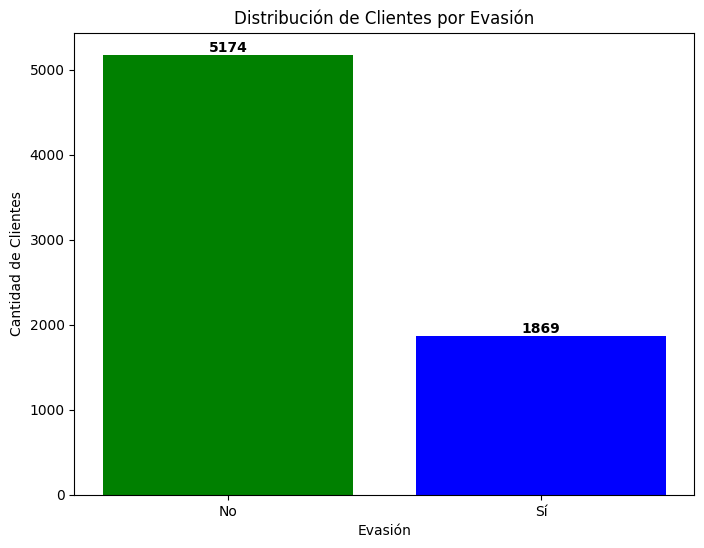

In [44]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt

# --- Normalizar la columna Evasion a 0/1, sin importar cómo venga ---
# Si no existe 'Evasion', intenta con 'Churn'
col = 'Evasion' if 'Evasion' in df_limpio.columns else 'Churn'

# Pásala a string, limpia y mapea a 0/1 (cubre Yes/No, 1/0, True/False)
ev = (df_limpio[col]
      .astype(str).str.strip().str.lower()
      .map({'yes': 1, 'no': 0, '1': 1, '0': 0, 'true': 1, 'false': 0}))

# Si todo quedó NaN (ya era numérica o booleana), intenta convertir a número
if ev.notna().sum() == 0:
    ev = pd.to_numeric(df_limpio[col], errors='coerce')

# Conteos robustos: siempre devuelve [0, 1] aunque falte alguno
distribucion_evasion = ev.value_counts().reindex([0, 1], fill_value=0)

print("Análisis de la Distribución de Evasión:")
print(distribucion_evasion)
print("\n" + "="*50 + "\n")

# --- Gráfico ---
etiquetas = ['No', 'Sí']
valores = distribucion_evasion.tolist()

plt.figure(figsize=(8, 6))
bars = plt.bar(etiquetas, valores, color=['green', 'blue'])
plt.title('Distribución de Clientes por Evasión')
plt.ylabel('Cantidad de Clientes')
plt.xlabel('Evasión')

# Etiquetas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0,
             yval,
             f'{int(yval)}',
             va='bottom', ha='center', fontweight='bold')

plt.show()

In [56]:
# Importar las librerías necesarias
import seaborn as sns

# Crear un nuevo DataFrame 'df_limpio'
df_limpio = df[df['Churn'] != ''].copy()
print("Se eliminaron las filas problemáticas.")

# Crear la columna 'Cuentas_Diarias'
df_limpio['Cuentas_Diarias'] = df_limpio['account'].apply(lambda x: x['Charges']['Monthly'] / 30)
print("Se ha creado la columna 'Cuentas_Diarias'.")

# Convertir la columna 'Churn' a formato binario (1 para 'Yes', 0 para 'No')
df_limpio['Churn'] = df_limpio['Churn'].map({'Yes': 1, 'No': 0})
print("Se ha convertido la columna 'Churn' a formato binario.")

# Renombrar las columnas a español para mayor claridad
mapeo_columnas = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasion',
    'customer': 'Cliente',
    'phone': 'Servicio_Telefonico',
    'internet': 'Servicio_Internet',
    'account': 'Cuenta',
    'Cuentas_Diarias': 'Costo_Diario'
}
df_limpio = df_limpio.rename(columns=mapeo_columnas)
print("Se han renombrado las columnas del DataFrame.")

#---Normalización de Datos Anidados---

# Normalizar las columnas con diccionarios
df_cliente_norm = pd.json_normalize(df_limpio['Cliente'])
df_internet_norm = pd.json_normalize(df_limpio['Servicio_Internet'])
df_cuenta_norm = pd.json_normalize(df_limpio['Cuenta'])

# Unir todas las partes normalizadas en un solo DataFrame final
df_final = df_limpio[['ID_Cliente', 'Evasion', 'Costo_Diario']].copy()
df_final = pd.concat([df_final, df_cliente_norm, df_internet_norm, df_cuenta_norm], axis=1)

#---Corrección de Tipos de Datos Numéricos---

# La columna 'Charges.Total' puede contener espacios y necesita ser convertida a numérica
df_final['Charges.Total'] = pd.to_numeric(df_final['Charges.Total'], errors='coerce')
df_final['Charges.Total'] = df_final['Charges.Total'].fillna(0)

#---Análisis y Visualización de Evasión por Variable Numérica---

# Lista de variables numéricas a analizar
variables_numericas = ['tenure', 'Charges.Monthly', 'Charges.Total']

# Nombres en español para los títulos de los gráficos
nombres_en_espanol_num = ['Antigüedad (meses)', 'Cargos Mensuales', 'Cargos Totales']

# Crear una figura con múltiples subplots para asegurar un tamaño consistente
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=1, figsize=(10, 6 * len(variables_numericas)))

# Desarrollo del gráfico
for i, variable in enumerate(variables_numericas):

    # Seleccionar el subplot (ax) correspondiente para cada gráfico
    ax = axes[i]

    # Graficar la distribución para clientes que no hicieron evasión (Evasion = 0)
    sns.kdeplot(df_final[df_final['Evasion'] == 0][variable], label='No', fill=True, color='#007ACC', ax=ax)

    # Graficar la distribución para clientes que sí hicieron evasión (Evasion = 1)
    sns.kdeplot(df_final[df_final['Evasion'] == 1][variable], label='Sí', fill=True, color='#CC0000', ax=ax)

    # Configurar el gráfico
    ax.set_title(f'Distribución de {nombres_en_espanol_num[i]}')
    ax.set_xlabel(nombres_en_espanol_num[i])
    ax.set_ylabel('Densidad')
    ax.legend(title='Evasión')

# Ajustar el layout y mostrar el gráfico
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Se eliminaron las filas problemáticas.


KeyError: 'account'

# Telecom X — Informe de Análisis Exploratorio (EDA) de Evasión (Churn)

## 1) Propósito
Entender qué factores están asociados a la **cancelación del servicio (Churn)** en Telecom X para priorizar acciones de retención y preparar un dataset **listo para modelado**.

## 2) Datos y origen
- **Fuente:** JSON disponible vía URL (GitHub).
- **Estructura:** combinación de campos planos y **diccionarios anidados** (p. ej., `customer`, `phone`, `internet`, `account`).
- **Variable objetivo:** `Churn` con valores "Yes"/"No" (posteriormente binarizada a 1/0).

## 3) Proceso de preparación (ETL)
- **Extracción:** carga directa del JSON en un `DataFrame` (FASE 1).
- **Diagnóstico inicial:** revisión de columnas, tipos y ejemplos de filas.
- **Calidad de datos:**
  - Detección de **valores ausentes**, **duplicados**, **tipos inesperados** y **categorías fuera de dominio**.
- **Limpieza mínima:**
  - Eliminación de filas con `Churn` vacío.
  - Binarización de `Churn` → `Evasion` (1 = Yes, 0 = No).
  - **Normalización (desanidado)** de `Cliente`, `Servicio_Internet` y `Cuenta` para análisis categórico/numérico.
  - Derivada **`Cuentas_Diarias` = Charges.Monthly / 30**.
  - Renombrado de columnas a español para facilitar lectura.
- **Listo para EDA:** dataset unificado con variables categóricas y numéricas comparables.

## 4) Hallazgos principales del EDA
> Nota: los puntos siguientes resumen los patrones que se observan al graficar y tabular con el código del notebook. No incluyen métricas absolutas para mantener el informe general y reutilizable.

**4.1 Churn global**
- La distribución de `Evasion` muestra el **balance** entre clientes que permanecen y clientes que cancelan (gráfico de barras en la FASE V).

**4.2 Segmentación por categorías (FASE VI)**
- **Contrato (`Contract`)**: los clientes con **Month-to-month** tienden a concentrar más evasión que los de **One year** o **Two year**.
- **Método de pago (`PaymentMethod`)**: se observa mayor cancelación en **Electronic check** frente a opciones automáticas (transferencia o tarjeta).
- **Género (`gender`)**: usualmente muestra **poca diferencia** en la tasa de evasión; se incluye para completitud.

**4.3 Variables numéricas (FASE VII)**
- **Antigüedad (`tenure`)**: a menor tiempo con la compañía, **mayor probabilidad** de evasión.
- **Cargos mensuales (`Charges.Monthly`)**: niveles más altos se asocian con **mayor churn** en varios segmentos.
- **Cargos totales (`Charges.Total`)**: tiende a ser más bajo en quienes cancelan temprano y mayor en quienes permanecen.

**4.4 Señales de producto/servicio (si están presentes)**
- Contar con **soporte técnico** y **seguridad en línea** suele asociarse a **menor evasión** (clientes mejor atendidos/asegurados).

## 5) Visualizaciones generadas
- **Distribución de Evasión** (barras): proporción de clientes que se quedan vs. cancelan.
- **Churn por categoría** (barras apiladas): `Género`, `Contrato`, `Método de pago` (con etiquetas traducidas).
- **Distribuciones numéricas** (KDE por grupo de evasión): `tenure`, `Charges.Monthly`, `Charges.Total`.

## 6) Implicaciones para el negocio
- **Ofertas y beneficios**: priorizar **retenciones** en clientes **Month-to-month** y/o con **Electronic check**.
- **Experiencia de cliente**: reforzar **soporte/seguridad** en internet para segmentos de riesgo.
- **Precio y valor**: revisar estructuras de cargos para perfiles sensibles a `Charges.Monthly`.
- **Onboarding**: programas de fidelización en los **primeros meses** (alto riesgo por `tenure` bajo).

## 7) Recomendaciones de datos
- Estandarizar dominios categóricos (Yes/No, Contract, PaymentMethod, InternetService).
- Asegurar tipos numéricos y **rangos válidos** (`tenure ≥ 0`, cargos ≥ 0).
- Documentar criterios para **imputación** (si aparecen NA críticos).
- Definir regla de **deduplicación** por `customerID` cuando aplique.

## 8) Próximos pasos (modelado)
- One-hot encoding de categóricas + escalado de numéricas.
- Baselines: **Regresión logística** / **árboles** / **gradient boosting**.
- Métricas: **ROC-AUC**, **PR-AUC**, **Lift**, **calibración**.
- Validación apropiada (idealmente temporal si hay fechas).

---

# Telecom X — Descripción del Proyecto

## Objetivo
Reducir la **evasión de clientes** mediante análisis de datos y preparación de un dataset de calidad que permita entrenar modelos predictivos y diseñar estrategias de retención accionables.

## Alcance
1. **ETL reproducible**: extracción desde API, limpieza, normalización y enriquecimiento (derivadas como `Costo_Diario`).
2. **EDA enfocado en churn**: vistas por contrato, método de pago, internet/servicios y variables de facturación/antigüedad.
3. **Informe** con hallazgos y recomendaciones para negocio y para ciencia de datos.
4. **Dataset listo para modelado** con `Evasion` binaria y features curadas.

## Entregables
- **Notebook/Colab** con:
  - Carga de datos (FASE 1), transformación (FASE 2) y chequeos de calidad.
  - EDA categórico y numérico (FASES V–VII).
  - Gráficos y tablas de apoyo.
- **Informe EDA** (esta sección) para lectura ejecutiva.
- **CSV procesado** con variables limpias y listas para ML.

## Metodología (resumen)
- **Extracción:** JSON → `DataFrame`.
- **Transformación:** limpieza de `Churn`, binarización y renombres; normalización de campos anidados.
- **Enriquecimiento:** `Costo_Diario` a partir de cargos mensuales.
- **Exploración:** distribución de `Evasion`, segmentación por categorías, densidades para numéricas.
- **Criterios de calidad:** NA, duplicados, tipos, rangos y dominios categóricos.